### ZTF Light Curve Plotting

Let's try plotting some light curves from that low luminosity sample to recreate [Das et al. 2025](https://arxiv.org/abs/2506.20068).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from alerce.core import Alerce
from astropy.stats import sigma_clipped_stats
from tqdm import tqdm
import time

In [2]:
df = pd.read_csv('data/ZTF_alerce_alerts.csv')
df

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF18aaszvfn,93,2072,58248.310775,59391.288310,False,False,40,-0.063799,0.865591,...,59391.288310,83.960486,215.782862,50.220817,0.000044,0.000022,NaN,NaN,NaN,correction_0.0.1
1,ZTF18abjndhh,66,397,58324.166528,58486.489676,False,False,11,0.377247,NaN,...,58486.489676,162.323148,173.179280,62.432761,0.000074,0.000027,NaN,NaN,NaN,corr_bulk_0.0.1
2,ZTF18abzrgim,32,75,58388.269190,58494.133542,False,False,26,0.336168,NaN,...,58494.133542,105.864352,346.885593,23.005797,0.000030,0.000021,NaN,NaN,NaN,corr_bulk_0.0.1
3,ZTF19aadnxnl,482,1220,58502.489664,58901.430382,False,False,109,0.255573,NaN,...,58901.430382,398.940718,203.811186,44.766284,0.000041,0.000025,NaN,NaN,NaN,corr_bulk_0.0.1
4,ZTF19aailepg,83,377,58514.464630,58661.200752,False,False,66,0.216761,NaN,...,58661.200752,146.736123,169.467734,30.156520,0.000039,0.000040,NaN,NaN,NaN,corr_bulk_0.0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,ZTF24aafqzur,55,943,60355.520359,60471.292118,True,False,36,NaN,NaN,...,60471.292118,115.771759,216.488345,-2.392265,0.008317,0.008309,NaN,NaN,NaN,24.5.1
104,ZTF24aagupsf,183,3955,60374.513438,60473.367002,False,False,56,NaN,NaN,...,60473.367002,89.952558,247.672867,44.511143,0.010341,0.007374,NaN,NaN,NaN,24.5.1
105,ZTF24aajxppf,113,2120,60416.479329,60555.171528,True,False,81,NaN,NaN,...,60555.171528,136.799097,269.590144,9.681528,0.038562,0.038013,NaN,NaN,NaN,24.5.2a6
106,ZTF24aaplfjd,174,2001,60460.465995,60581.460706,True,False,63,NaN,NaN,...,60581.460706,120.994711,14.505587,30.706595,0.098861,0.085000,NaN,NaN,NaN,24.5.2a6


In [23]:
## Using a lot of Viraj's code from LSST CCA Summer School

# Color config for filters
colors = {1: "green", 2: "red"}
labels = {1: 'g', 2: 'r'}
markers = {1: 'o', 2: 's'}
sizes = {1: 30, 2: 60}


def query_all_detections(oid, client, page_size=10000):
    """Fetch all detection rows for a given oid from ALeRCE."""
    all_dets = []
    page = 1
    while True:
        dets = client.query_detections(
            oid, format='pandas', page=page, page_size=page_size
        )
        if dets.empty:
            break
        all_dets.append(dets)
        page += 1
    return pd.concat(all_dets, ignore_index=True) if all_dets else pd.DataFrame()


def query_all_nondetections(oid, client, page_size=10000):
    """Fetch all non-detection rows for a given oid from ALeRCE."""
    all_nd = []
    page = 1
    while True:
        nd = client.query_non_detections(
            oid, format='pandas', page=page, page_size=page_size
        )
        if nd.empty:
            break
        all_nd.append(nd)
        page += 1
    return pd.concat(all_nd, ignore_index=True) if all_nd else pd.DataFrame()

def plotStamps(oid, lc_det, client):
    # Find first detection with a valid stamp
    if "has_stamp" not in lc_det.columns or lc_det["has_stamp"].sum() == 0:
        print(f"⚠️ No stamp available for {oid}")
        return

    try:
        candid = lc_det.loc[lc_det.has_stamp].sort_values("mjd").candid.iloc[0]
        stamps = client.get_stamps(oid, candid, format='HDUList')
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
    except Exception as e:
        print(f"❌ Failed to fetch stamps for {oid}: {e}")
        return

    # Plot the cutouts
    fig, ax = plt.subplots(ncols=3, figsize=(8, 4))
    titles = ["Science", "Reference", "Difference"]
    images = [science, ref, difference]

    for i in range(3):
        img = np.log1p(images[i])  # log scale with log1p for stability
        _, med, std = sigma_clipped_stats(img, sigma=3.0)
        ax[i].imshow(img, cmap='viridis', origin='lower')
        ax[i].set_title(titles[i])
        ax[i].axis("off")

    fig.suptitle(f"{oid}, candid: {candid}", fontsize=12, y=0.9)
    plt.tight_layout()
    plt.show()

def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize=(9, 5))

    # Loop over whatever filters are actually present
    for fid in sorted(SN_det.fid.dropna().unique()):
        color = colors.get(fid, "black")
        label = labels.get(fid, f"fid={fid}")
        marker = markers.get(fid, "o")
        size = sizes.get(fid, 40)

        # --- Detections ---
        mask_det = (SN_det.fid == fid) & SN_det.magpsf.notna()
        if mask_det.any():
            ax.errorbar(
                SN_det.loc[mask_det, "mjd"],
                SN_det.loc[mask_det, "magpsf"],
                yerr=SN_det.loc[mask_det, "sigmapsf"],
                c=color, label=label,
                marker=marker, linestyle='none'
            )

        # --- Non-detections (limits) ---
        mask_nondet = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > 0)
        if mask_nondet.any():
            ax.scatter(
                SN_nondet.loc[mask_nondet, "mjd"],
                SN_nondet.loc[mask_nondet, "diffmaglim"],
                c=color, alpha=0.5, marker='v',
                label=f"lim.mag. {label}", s=size
            )

    ax.set_title(oid, fontsize=16)
    ax.set_xlabel("MJD", fontsize=14)
    ax.set_ylabel("Apparent magnitude", fontsize=14)

    # Flip y-axis so brighter = up
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.legend()
    ax.grid(True, alpha=0.4)

    plt.tight_layout()
    plt.show()

def get_lc_data(oid, client, doLC=False, doStamps=False):
    results = {"oid": oid}

    try:
        lc_det = client.query_detections(oid, format='pandas').sort_values("mjd")
        results["lc_det"] = lc_det
    except Exception as e:
        print(f"⚠️ Could not fetch detections for {oid}: {e}")
        lc_det = pd.DataFrame()

    try:
        lc_nondet = client.query_non_detections(oid, format='pandas').sort_values("mjd")
        results["lc_nondet"] = lc_nondet
    except Exception as e:
        print(f"⚠️ Could not fetch non-detections for {oid}: {e}")
        lc_nondet = pd.DataFrame()

    if doLC and not lc_det.empty and not lc_nondet.empty:
        plotLC(oid, lc_det, lc_nondet)

    if doStamps and not lc_det.empty:
        plotStamps(oid, lc_det, client)

    return results

Let's plot **ZTF22abtspsw/SN 2022aagp** which had the steepest observed drop of $>3.5$ mag.

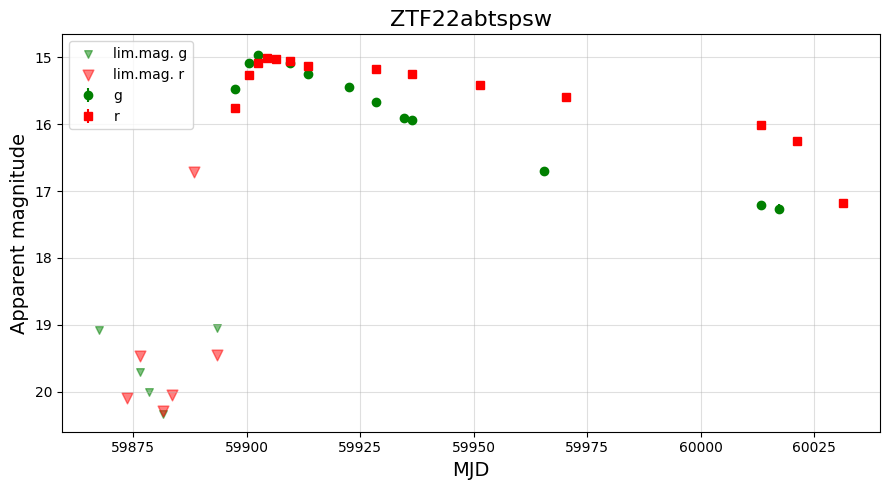

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


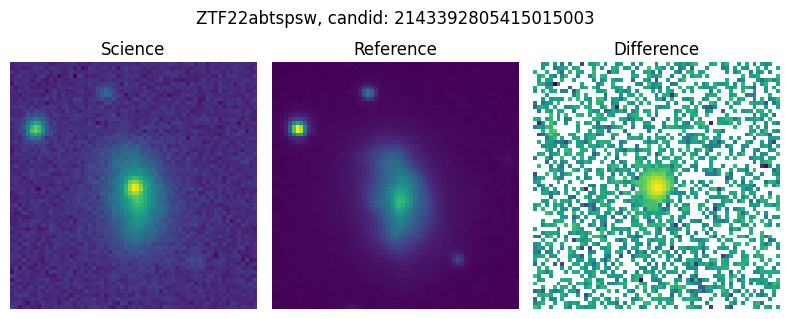

In [26]:
alerce = Alerce()
_ = get_lc_data('ZTF22abtspsw', alerce, doLC=True, doStamps=True)

Ok I think the reason we are missing the tail is because ALeRCE only does non-detections before the first detection. So we might need to query forced photometry?

In [29]:
df[df['oid'] == "ZTF22abtspsw"]

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
77,ZTF22abtspsw,39,1007,59897.5,60031.25,False,False,26,-0.049599,NaN,...,60031.261644,133.868843,137.674607,7.205662,0.000024,0.000026,NaN,NaN,NaN,1.1.6


No irsa account setup, please provide it


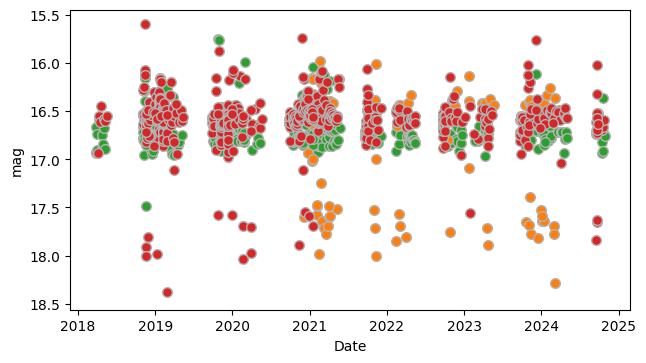

In [30]:
from ztfquery import lightcurve
lcq = lightcurve.LCQuery.from_position(137.674607, +7.205662, 5)
lcq.show()

  0%|          | 0/10 [00:00<?, ?it/s]

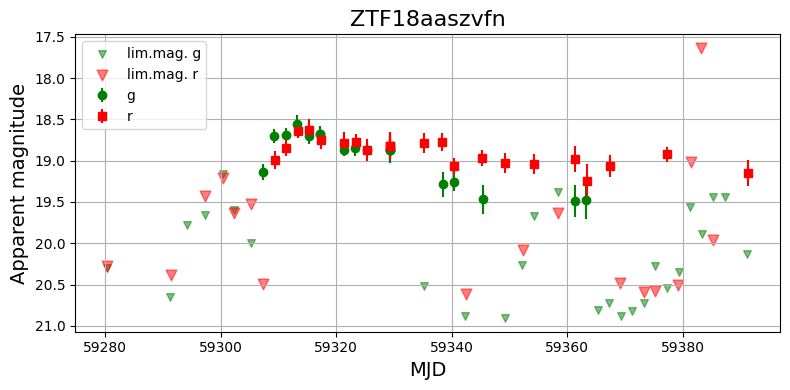

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/1440154891.py:29: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


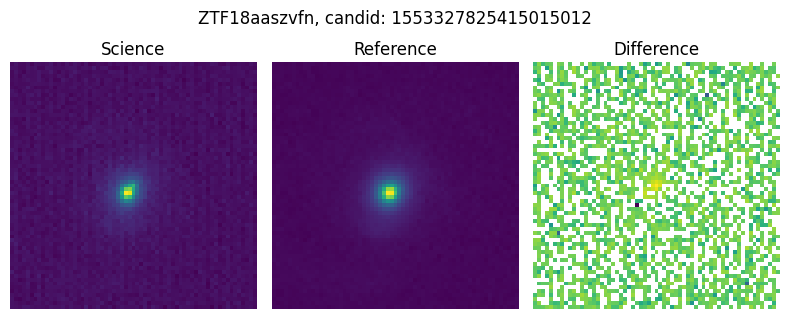

 10%|█         | 1/10 [00:02<00:22,  2.47s/it]

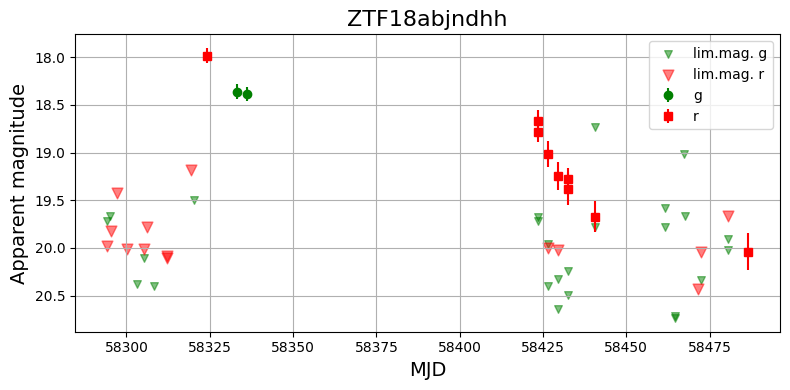

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/1440154891.py:29: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


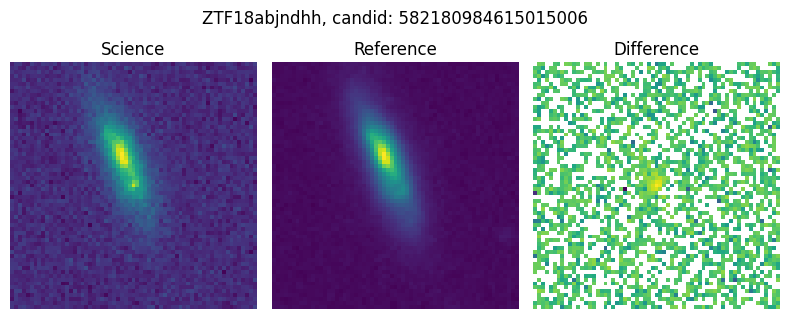

 20%|██        | 2/10 [00:04<00:16,  2.01s/it]

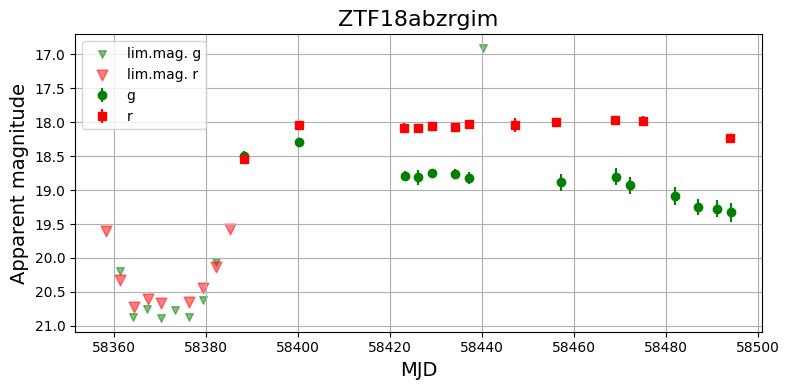

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/1440154891.py:29: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


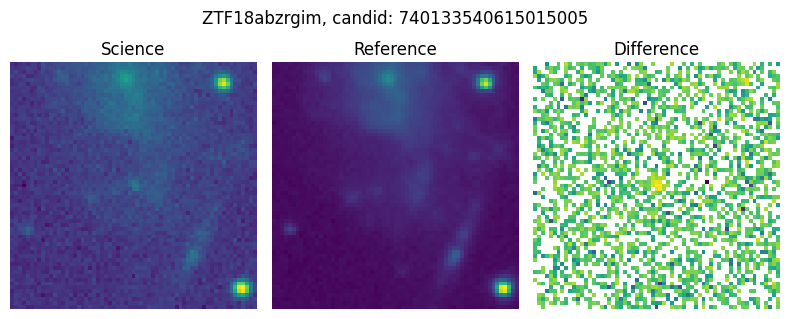

 30%|███       | 3/10 [00:05<00:12,  1.84s/it]

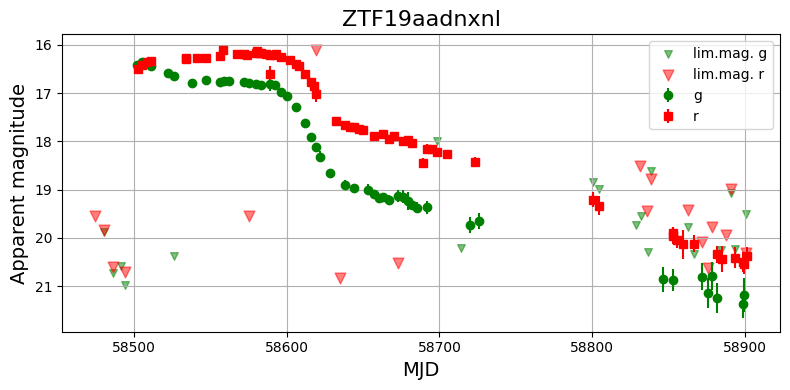

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/1440154891.py:29: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


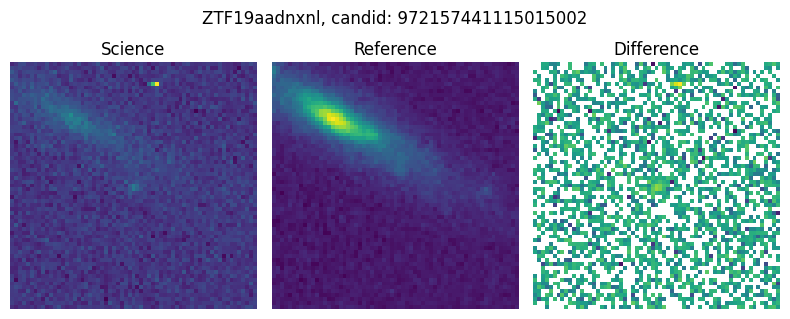

 40%|████      | 4/10 [00:07<00:11,  1.87s/it]

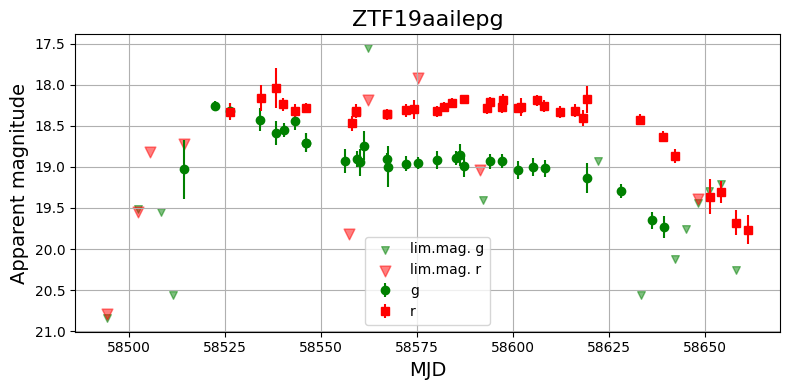

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/1440154891.py:29: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


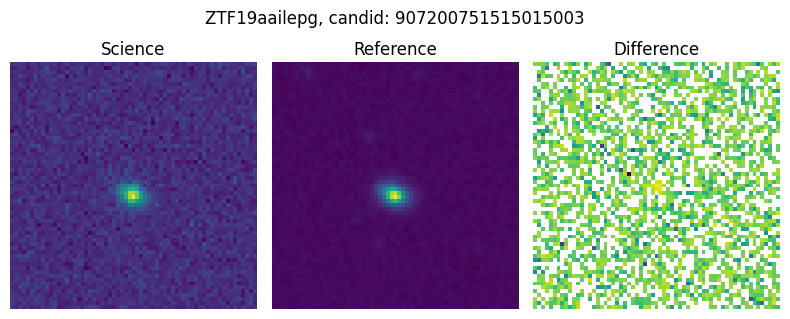

 50%|█████     | 5/10 [00:09<00:09,  1.90s/it]

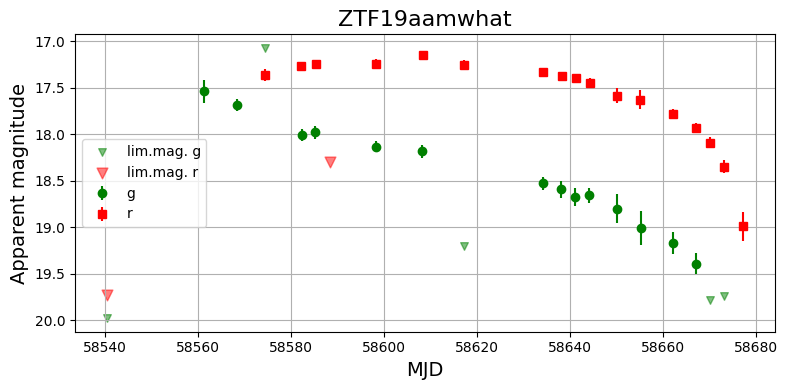

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/1440154891.py:29: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


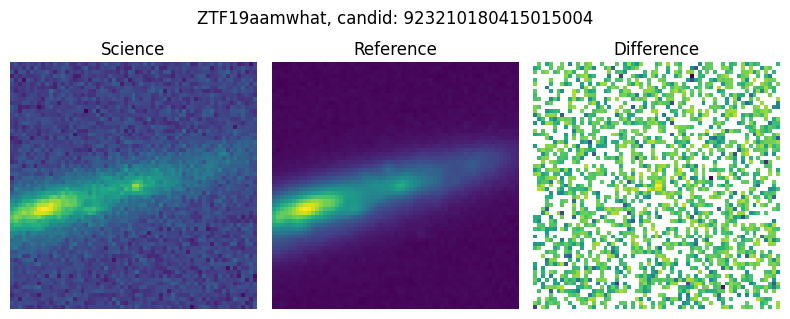

 60%|██████    | 6/10 [00:11<00:07,  1.79s/it]

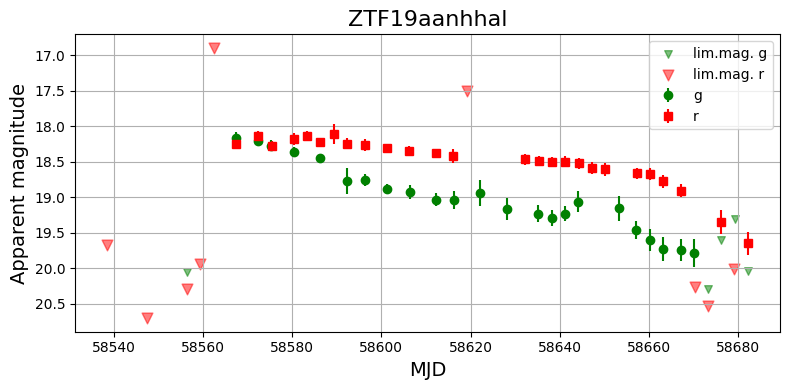

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/1440154891.py:29: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


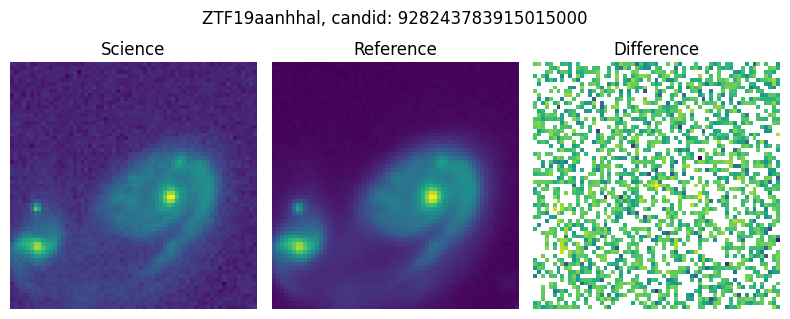

 70%|███████   | 7/10 [00:13<00:05,  1.80s/it]

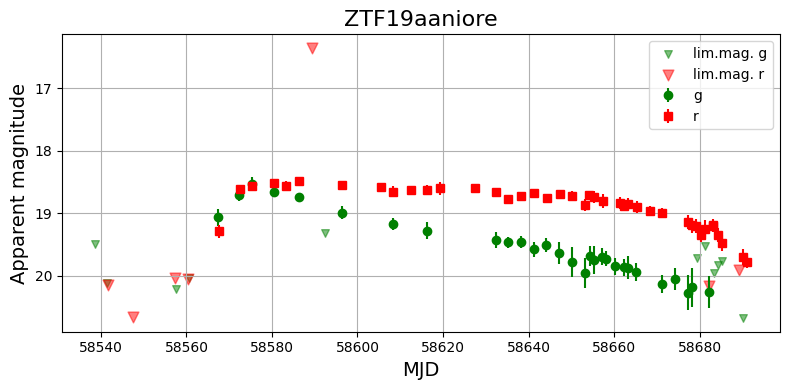

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/1440154891.py:29: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


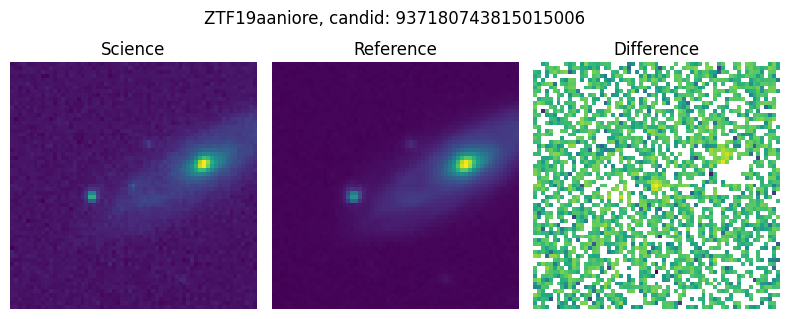

 80%|████████  | 8/10 [00:14<00:03,  1.77s/it]

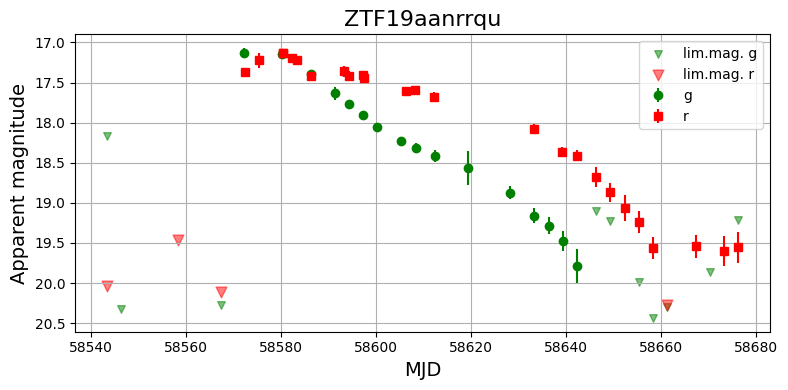

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/1440154891.py:29: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


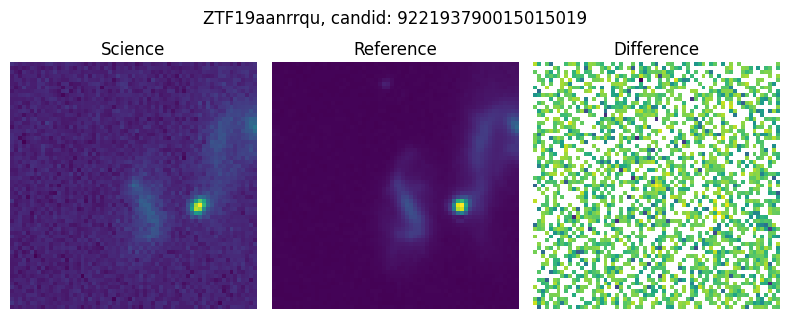

 90%|█████████ | 9/10 [00:16<00:01,  1.80s/it]

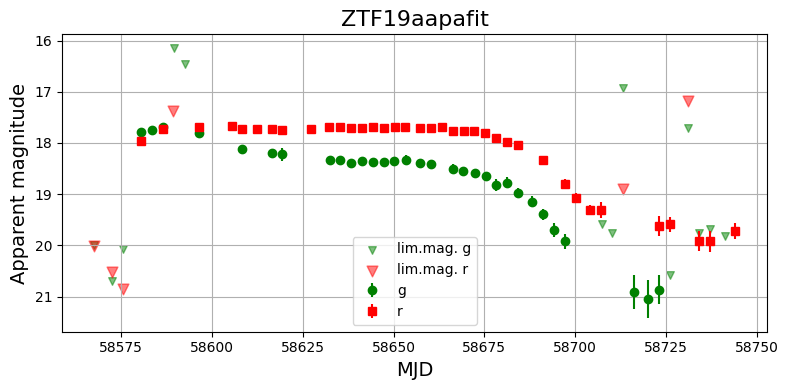

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_4825/1440154891.py:29: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


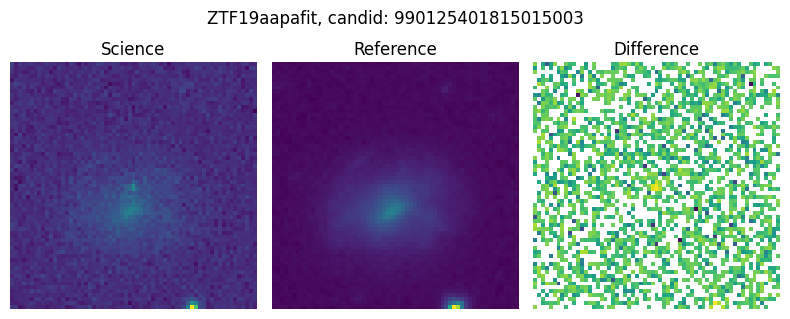

100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


In [ ]:
for ind in tqdm(range(len(df[:10]))):
    _ = get_lc_data(
        df.iloc[ind]['oid'],
        alerce,
        doLC=True,
        doStamps=True
    )